In [482]:
import pandas as pd
import numpy as np
import json
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

#### 爬取湖南省身高153cm-170cm小姐姐数据，年龄范围20-35岁

### 原始数据提取

In [471]:
# 不用科学计数显示，保留小数点二位
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [472]:
item_list = []
with open("girls_153-170_66min.json", "r", encoding="utf8") as fp:
    for line in fp:
        js_to_dict = json.loads(line)
        item_list.append(js_to_dict)

In [473]:
raw_data = pd.DataFrame(item_list, columns=["user_id", "nickname", "age", "degree", "height","marriage", "salary", "age_boy", "height_boy", "degree_boy", "marriage_boy"])
raw_data.head(3)

,user_id,nickname,age,degree,height,marriage,salary,age_boy,height_boy,degree_boy,marriage_boy
0,217276561,注定,27,大专,162cm,离异,2000～5000元,26-34岁之间,162-187厘米,不限,不限
1,35161894,菲菲,33,本科,163cm,离异,2000～5000元,26-45岁之间,173-190厘米,不限,不限
2,218231396,清风,29,高中中专及以下,160cm,未婚,5000～10000元,28-36岁之间,160-185厘米,不限,不限


In [481]:
raw_data["user_id"].count()

18451

#### 总共爬取18451条数据

### 去重

In [459]:
data_unique = raw_data.drop_duplicates().reset_index(drop=True)  # 舍弃掉重复项，重新建立索引（drop=true表示把原来的索引舍弃，否则原来的也会保留）
data_unique.head(5)

,user_id,nickname,age,degree,height,marriage,salary,age_boy,height_boy,degree_boy,marriage_boy
0,217276561,注定,27,大专,162cm,离异,2000～5000元,26-34岁之间,162-187厘米,不限,不限
1,35161894,菲菲,33,本科,163cm,离异,2000～5000元,26-45岁之间,173-190厘米,不限,不限
2,218231396,清风,29,高中中专及以下,160cm,未婚,5000～10000元,28-36岁之间,160-185厘米,不限,不限
3,217009646,燕子,32,大专,156cm,丧偶,5000～10000元,31-39岁之间,170-181厘米,不限,不限
4,217023683,波波,26,本科,163cm,未婚,10000～20000元,30-50岁之间,不限,不限,不限


In [469]:
data_unique["user_id"].count()

2290

#### 去重后剩余2290条数据，造假近10倍

### 去重后的操作

In [461]:
data_unique[data_unique["degree"]== "本科"]["user_id"].count()

1098

In [462]:
data_unique["height"] = data_unique["height"].str.replace("cm", "").astype("float")
data_unique.head(5)

,user_id,nickname,age,degree,height,marriage,salary,age_boy,height_boy,degree_boy,marriage_boy
0,217276561,注定,27,大专,162.00,离异,2000～5000元,26-34岁之间,162-187厘米,不限,不限
1,35161894,菲菲,33,本科,163.00,离异,2000～5000元,26-45岁之间,173-190厘米,不限,不限
2,218231396,清风,29,高中中专及以下,160.00,未婚,5000～10000元,28-36岁之间,160-185厘米,不限,不限
3,217009646,燕子,32,大专,156.00,丧偶,5000～10000元,31-39岁之间,170-181厘米,不限,不限
4,217023683,波波,26,本科,163.00,未婚,10000～20000元,30-50岁之间,不限,不限,不限


In [463]:
temp_height = data_unique["height_boy"].str.split("-", n=1, expand=True)[0]  # expand=True按分割结果返回一个dataframe，所以取[0]就是取第一列

temp_height = temp_height.str.replace("厘米或以上", "")

temp_height.replace("不限", "0", inplace=True) # inplace表示原地修改

temp_height[temp_height.str.contains("厘米或以下", regex=False)] = "0"  # 把诸如"195cm以下这种替换为0"

temp_height[temp_height=="0"] = np.nan

temp_height = temp_height.astype("float")

temp_height.fillna(temp_height.mean(), inplace=True)

# temp_height.isnull()  # 高版本增加isna()函数，功能和isnull()一样
# temp_height[temp_height.isnull()]

data_unique["height_boy"] = temp_height

data_unique["height_boy"].describe()

count   2290.00
mean     169.77
std        4.66
min      130.00
25%      168.00
50%      170.00
75%      172.00
max      181.00
Name: height_boy, dtype: float64

In [464]:
data_unique = data_unique.sort_values(by=["height", "height_boy"]).reset_index(drop=True)

In [479]:
data_unique.head(5)

,user_id,nickname,age,degree,height,marriage,salary,age_boy,height_boy,degree_boy,marriage_boy
0,175492367,梦儿,30,大专,153.00,"离异,有孩子跟着对方",2000元以下,29-40岁之间,163.00,不限,未婚
1,142015297,"嗨,我就是我",29,本科,153.00,未婚,2000～5000元,26-35岁之间,165.00,本科,不限
2,100643150,vila,31,硕士,153.00,未婚,5000～10000元,29-38岁之间,165.00,本科或以上,不限
3,185585039,五月,27,硕士,153.00,未婚,5000～10000元,25-35岁之间,167.00,本科,未婚
4,118103924,我,33,大专,153.00,离异,2000～5000元,30-40岁之间,168.00,不限,不限


In [466]:
group = data_unique["height_boy"].groupby(data_unique["height"])
max_value = group.max().tolist()
avg_value = group.mean().tolist()
mid_value = group.median().tolist()
max_value = group.max().tolist()

In [467]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

x = list(range(153, 171))
y = list(range(160, 190))

y1 = mid_value
y2 = avg_value
y3 = list(range(153, 171))
y4 = max_value

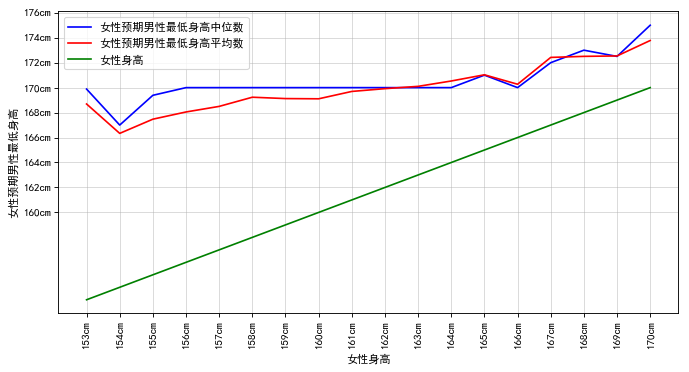

In [480]:
plt.figure(figsize=(10, 5), dpi=80)

x_label = [str(item) + "cm" for item in x]
y_label = [str(item) + "cm" for item in y]
    
plt.xticks(x, x_label, rotation=90)
plt.yticks(y[::2], y_label[::2])

plt.xlabel("女性身高")
plt.ylabel("女性预期男性最低身高")

plt.plot(x, y1, label="女性预期男性最低身高中位数", color="blue")
plt.plot(x, y2, label="女性预期男性最低身高平均数", color="red")
plt.plot(x, y3, label="女性身高", color="green")
# plt.plot(x, y4)

plt.legend(loc="upper left")
plt.grid(alpha=0.5, linestyle="-")

plt.show()